In [119]:
import mudata as md
from mudata import MuData

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_curve, roc_curve, auc

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [181]:
!wget https://github.com/IGVF-CRISPR/CRISPR-JAMBOREE/raw/main/single-cell/simulation/gasperini_simulation_output_scanpy_wilcoxon.h5mu

--2024-02-23 20:26:04--  https://github.com/IGVF-CRISPR/CRISPR-JAMBOREE/raw/main/single-cell/simulation/gasperini_simulation_output_scanpy_wilcoxon.h5mu
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IGVF-CRISPR/CRISPR-JAMBOREE/main/single-cell/simulation/gasperini_simulation_output_scanpy_wilcoxon.h5mu [following]
--2024-02-23 20:26:04--  https://raw.githubusercontent.com/IGVF-CRISPR/CRISPR-JAMBOREE/main/single-cell/simulation/gasperini_simulation_output_scanpy_wilcoxon.h5mu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7084847 (6.8M) [application/octet-stream]
Saving to: ‘gasperini_simulati

In [200]:
# gasperini_output = md.read_h5mu('../inference/PerTurbo-Python/gasperini_inference_output_perturbo.h5mu')
gasperini_output = md.read_h5mu('gasperini_simulation_output_scanpy_wilcoxon.h5mu')

In [204]:
def perform_binary_evaluation(mdata, table_name, effect_size_col, infered_significance_col, plot=True):
    true_label = mdata.uns[table_name][effect_size_col] != 1
    pred_value = mdata.uns[table_name][infered_significance_col]
    pre, rec, _ = precision_recall_curve(true_label, pred_value)
    auprc = auc(rec, pre)
    fpr, tpr, _ = roc_curve(true_label, pred_value)
    auroc = auc(fpr, tpr)
    print(f"Area under Precision-Recall Curve : {auprc:.3f}\n" + 
          f"Area under Receiver-Operating Curve: {auroc:.3f}\n")
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=130, )
        axes[0].plot(rec, pre, lw=1, label=f"AUPRC={auprc:.3f}")
        axes[1].plot(fpr, tpr, lw=1, label=f"AUROC={auroc:.3f}")
        axes[0].set_xlabel("Recall")
        axes[0].set_ylabel("Precision")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[0].legend()
        axes[1].legend()
        plt.tight_layout()
        plt.show()

def perform_continuous_evaluation(mdata, table_name, effect_size_col, estimated_effect_size_col, plot=True):
    true_effect = np.log2(mdata.uns[table_name][effect_size_col])
    pred_effect =         mdata.uns[table_name][estimated_effect_size_col]
    correlation = sp.stats.pearsonr(true_effect, pred_effect).statistic
    MSE = ((true_effect - pred_effect) ** 2).mean()
    print(f"Correlation of Log Fold Change: {correlation:.3f}\n" + 
          f"Mean : {MSE:.3f}\n")
    
    if plot:
        fig = plt.figure(figsize=(5, 4), dpi=130, )
        plt.scatter(true_effect, pred_effect, lw=1, label=f"Correlation={correlation:.3f}")
        plt.xlabel("True Log Fold Change")
        plt.ylabel("Estimated Log Fold Change")
        plt.legend()
        plt.show()

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Area under Precision-Recall Curve : 1.000
Area under Receiver-Operating Curve: nan



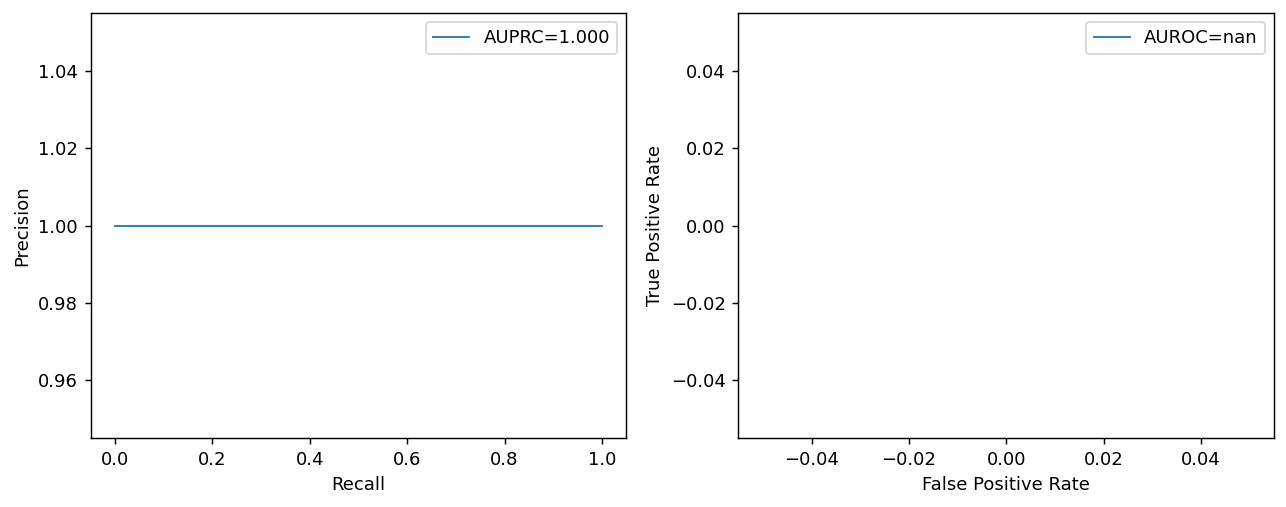

In [205]:
perform_binary_evaluation(mdata=gasperini_output, 
                          table_name='test_results',
                          effect_size_col='effect_size', 
                          infered_significance_col='p_value')

Correlation of Log Fold Change: nan
Mean : 1.877



/tmp/ipykernel_163/554722310.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation = sp.stats.pearsonr(true_effect, pred_effect).statistic


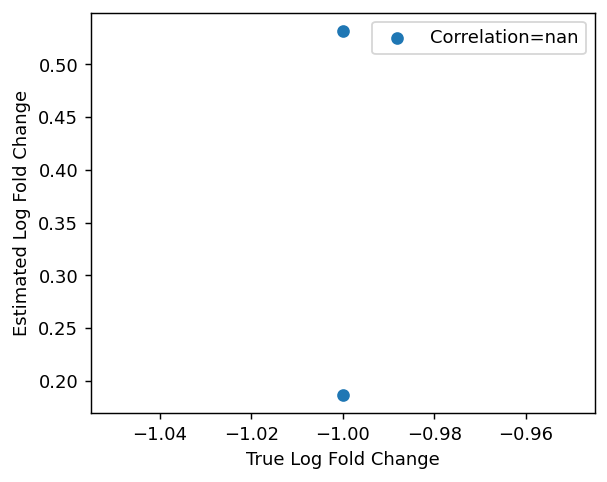

In [207]:
perform_continuous_evaluation(mdata=gasperini_output, 
                              table_name='test_results', 
                              effect_size_col='effect_size', 
                              estimated_effect_size_col='log2_fc', 
                              plot=True)

In [265]:
def visualize_clustergram(mdata):
    guide_mask = mdata['guide'].X != 0
    all_gex = mdata['gene'].X.sum(axis=0)
    
    guide_per_gex = list()
    for col in range(guide_mask.shape[1]):
        guide_col = guide_mask[:, col]
        has_guide = np.where(guide_col.todense())[0]
        sum_gex_wi = mdata['gene'][has_guide].X.sum(axis=0)
        sum_gex_wo = all_gex - sum_gex_wi
        mean_gex_wi = sum_gex_wi /  has_guide.shape[0]
        mean_gex_wo = sum_gex_wo / (mdata['gene'].shape[0] - has_guide.shape[0]) 
        lfc = np.log2(mean_gex_wi / mean_gex_wo)
        lfc[~np.isfinite(lfc)] = 0
        guide_per_gex.append(np.array(lfc).flatten())
    guide_per_gex = np.array(guide_per_gex)
    sns.clustermap(pd.DataFrame(guide_per_gex, 
                                columns=mdata['gene'].var.index, 
                                index=mdata['guide'].var.index),
                   cmap="coolwarm", center=0, figsize=(6,6))

/tmp/ipykernel_163/1093942456.py:13: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2(mean_gex_wi / mean_gex_wo)


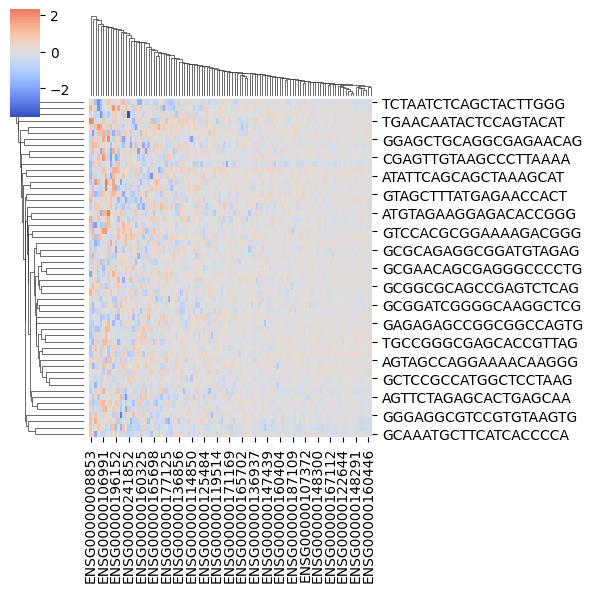

In [266]:
visualize_clustergram(gasperini_output)